# Demo 10 : Decision 🌳s 

In this demo, you will implement:
- training a decision tree
- training a random forest


# Prepare the data

We will use the Iris dataset again. Start by loading the data and splitting it into train/test sets.

In [4]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import datasets

iris = datasets.load_iris()

# Split into train/test
from sklearn.model_selection import train_test_split

(iris_train_x, iris_test_x, 
 iris_train_y, iris_test_y) = train_test_split(iris.data, iris.target, test_size=100)

print(iris.data.shape)

(150, 4)


# Models

## Decision tree

First, we will implement the basic decision tree.

In [105]:
from collections import Counter

def get_majority_class(labels):
    counts = Counter(labels)
    return counts.most_common(1)[0][0]

def compute_entropy(labels):
    counts = Counter(labels)
    counts = np.array([counts[key] for key in counts])
    frequencies = counts/counts.sum()
    entropy = -(frequencies * np.log(frequencies)).sum()
    return entropy

class Node():
    def __init__(self):
        self.threshold = None
        self.col = None
        self.is_leaf = None
        self.output_class = None
        
    def find_best_question(self, x, y):
        best_col = None
        best_val = None
        best_loss = np.inf
        
        num_cols = x.shape[1]
        valid_cols = np.arange(num_cols)
        for col in valid_cols:
            sorted_indices = x[:, col].argsort()
            sorted_vals = x[sorted_indices, col]
            midpoints = [(sorted_vals[i] + sorted_vals[i+1])/2 for i in range(len(sorted_vals)-1) ]
            for val in midpoints:
                right_subset_rows = x[:, col] > val 
                left_subset_rows = np.invert(right_subset_rows)
                right_labels = y[right_subset_rows]
                left_labels = y[left_subset_rows]      
                
                right_entropy = compute_entropy(right_labels)
                left_entropy = compute_entropy(left_labels)
                loss = left_entropy + right_entropy
                if loss < best_loss:
                    best_loss = loss
                    best_col = col
                    best_val = val
                    
        self.col = best_col
        self.threshold = best_val
    
    def ask_question(self, x):
        if not self.is_leaf:
            return x[:, self.col] > self.threshold
        else:
            print("Error: leaf nodes cannot ask questions!")
            return False
    
    def predict(self):
        if self.is_leaf:
            return self.output_class
        else:
            print("Error: non-leaf nodes cannot make a prediction!")
            return None
    
class MyDecisionTreeClassifier():
    def __init__(self, max_depth=1):
        self.max_depth = max_depth
    
    def create_node(self, x_subset, y_subset, depth):
        # Recursive function
        node = Node()
        
        majority_class = get_majority_class(y_subset)
        majority_class_count = (y_subset == majority_class).sum()
        perfectly_classified = majority_class_count == len(y_subset)
        
        if perfectly_classified or depth == self.max_depth:
            node.is_leaf = True
            node.output_class = majority_class
        else:
            node.is_leaf = False
            node.find_best_question(x_subset,y_subset)
            right_subset_rows = node.ask_question(x_subset) 
            left_subset_rows = np.invert(right_subset_rows)
            node.left_child = self.create_node(x_subset[left_subset_rows], y_subset[left_subset_rows],  depth+1)
            node.right_child = self.create_node(x_subset[right_subset_rows], y_subset[right_subset_rows], depth+1)
        
        return node
    
    def fit(self, x, y):
        self.root_node = self.create_node(x,y,depth=1)
    
    def predict(self, x):
        predictions = []
        
        for i in range(len(x)):
            current_node = self.root_node
            x_i = x[i].reshape(1,-1)
            done_traversing_tree = False
            while not done_traversing_tree:
                if current_node.is_leaf:
                    predictions.append(current_node.predict())
                    done_traversing_tree = True

                else:
                    if current_node.ask_question(x_i):
                        current_node = current_node.right_child
                    else:
                        current_node = current_node.left_child

        return np.array(predictions)
        

Try fitting

In [108]:
tree = MyDecisionTreeClassifier(max_depth=4)
# tree = sklearn.tree.DecisionTreeClassifier(max_depth=7)
tree.fit(iris_train_x, iris_train_y)
print(tree.predict(iris_test_x))
print(iris_test_y)
print("accuracy: ", (tree.predict(iris_test_x) == iris_test_y).mean() * 100, "\%")

[2 0 2 1 2 0 0 2 1 1 1 2 0 2 0 2 0 0 2 2 1 0 2 1 2 2 1 0 1 1 2 1 1 2 2 2 0
 1 0 0 2 0 1 0 0 2 2 2 0 0 1 0 0 1 1 0 0 1 2 1 1 1 2 0 0 0 2 1 2 0 1 1 2 1
 1 2 2 2 2 2 0 2 2 2 2 2 1 1 1 1 1 2 2 0 1 0 2 0 2 0]
[2 0 1 1 2 0 0 2 1 1 1 1 0 2 0 2 0 0 2 2 1 0 2 1 2 2 1 0 1 1 2 1 0 2 2 2 0
 1 0 0 2 0 1 0 0 2 2 2 0 0 1 0 0 1 1 0 0 1 1 1 1 1 2 0 0 0 2 1 2 0 1 1 1 0
 1 2 2 1 2 2 0 2 2 2 2 2 1 1 1 1 1 2 2 0 1 0 2 0 2 0]
accuracy:  93.0 \%


## Random forest

Next, we will implement the random forest model using our decision tree. 

A random forest is an ensemble of decision trees, where each tree is trained by randomizing the dataset set in some way.

We will explore two methods for randomizing the dataset: picking a random subset of rows (bagging), and picking a random subset of features.

In [33]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# tree = DecisionTreeClassifier()
tree = RandomForestClassifier(n_estimators=1)
tree.fit(iris_train_x, iris_train_y)
print(tree.predict(iris_test_x))

print(iris_test_y)
print((iris_test_y != tree.predict(iris_test_x)).sum())

[2 0 2 1 2 0 0 2 1 1 1 1 0 2 0 2 0 0 2 2 1 0 2 1 2 2 1 0 1 1 2 1 0 2 2 2 0
 1 0 0 2 0 1 0 0 2 2 2 0 0 1 0 0 1 1 0 0 1 2 1 1 1 2 0 0 0 2 1 2 0 1 1 2 0
 1 2 2 1 2 2 0 2 2 2 2 2 1 1 1 1 1 2 2 0 1 0 2 0 2 0]
[2 0 1 1 2 0 0 2 1 1 1 1 0 2 0 2 0 0 2 2 1 0 2 1 2 2 1 0 1 1 2 1 0 2 2 2 0
 1 0 0 2 0 1 0 0 2 2 2 0 0 1 0 0 1 1 0 0 1 1 1 1 1 2 0 0 0 2 1 2 0 1 1 1 0
 1 2 2 1 2 2 0 2 2 2 2 2 1 1 1 1 1 2 2 0 1 0 2 0 2 0]
3


Vary the maximum depth of the tree:

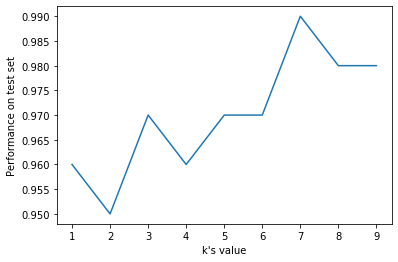

In [14]:
k_values = np.arange(1, 10)
k_perf = []

#TODO plot the validation curve for different k
for k in k_values:  # question
    k_tree = DecisionTreeClassifier(max_depth=k)
    k_tree.fit(iris_train_x, iris_train_y)
    test_pred = k_tree.predict(iris_test_x)
    k_perf.append((test_pred == iris_test_y).mean())

plt.xlabel('k\'s value')
plt.ylabel('Performance on test set')
plt.plot(k_values, k_perf)